# Face Recognition Pipeline using EfficientNet V2 M

This notebook implements a complete training pipeline for face recognition using the `efficientnet_v2_m` model from `torchvision`.

## Requirements
- **Model**: EfficientNet V2 M (pretrained)
- **Fine-tuning**: Freeze all layers except classifier and last two layers
- **Epochs**: 12
- **Batch Size**: 32
- **Patience**: 3 (Early Stopping)
- **Metrics**: Accuracy, Confusion Matrix

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, models

# Check device and CUDA availability
print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"Device Name: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA is NOT available. Running on CPU.")
    print("To fix this, you may need to reinstall PyTorch with CUDA support.")
    print("Run the following command in your terminal:")
    print("pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121 --force-reinstall")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

PyTorch Version: 2.5.1+cu121
CUDA Available: True
CUDA Version: 12.1
Device Name: NVIDIA GeForce RTX 4050 Laptop GPU
Using device: cuda


## Configuration

In [2]:
CSV_FILE = 'dataset.csv'
DATA_DIR = 'Train'
BATCH_SIZE = 32
EPOCHS = 12
PATIENCE = 3
LEARNING_RATE = 0.001
IMG_SIZE = 480 # EfficientNetV2-M default resolution

## Dataset Preparation

In [3]:
# Load CSV
df = pd.read_csv(CSV_FILE)

# Encode labels
label_map = {label: idx for idx, label in enumerate(df['label'].unique())}
idx_to_label = {idx: label for label, idx in label_map.items()}
df['label_idx'] = df['label'].map(label_map)

print(f"Total images: {len(df)}")
print(f"Total classes: {len(label_map)}")

# Use full dataset for training (no test/val split for now)
train_df = df
val_df = df # Use training data for validation to track convergence

print(f"Train set: {len(train_df)}")
print(f"Val set: {len(val_df)}")

Total images: 270
Total classes: 68
Train set: 270
Val set: 270


In [4]:
class FaceDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        img_name = row['gambar']
        label_name = row['label']
        label_idx = row['label_idx']
        
        # Construct full image path
        img_path = os.path.join(self.root_dir, label_name, img_name)
        
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            # Return a black image in case of error to prevent crash, or handle appropriately
            image = Image.new('RGB', (IMG_SIZE, IMG_SIZE))

        if self.transform:
            image = self.transform(image)

        return image, label_idx

In [5]:
# Transforms
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Datasets & Loaders
train_dataset = FaceDataset(train_df, DATA_DIR, transform=train_transform)
val_dataset = FaceDataset(val_df, DATA_DIR, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

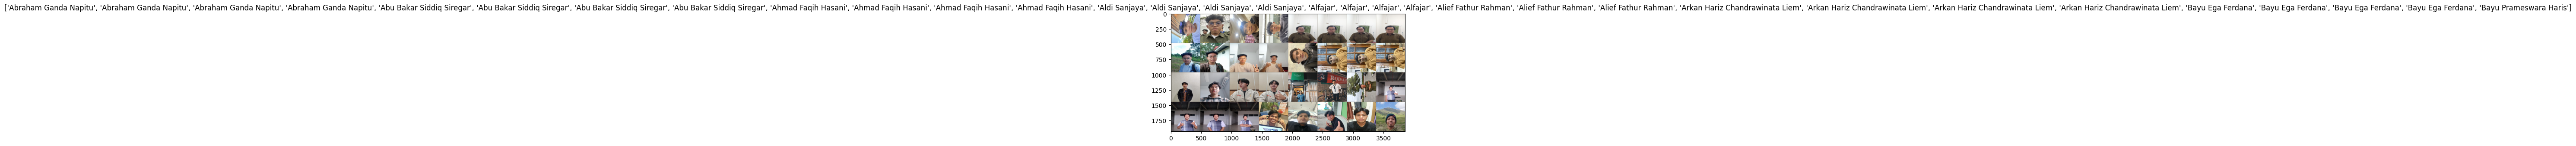

In [34]:
# Visualize one image after transform
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(val_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[:32])

plt.figure(figsize=(7, 7))
imshow(out, title=[idx_to_label[x.item()] for x in classes[:32]])

## Model Setup

In [6]:
def get_model(num_classes):
    # Load Pretrained EfficientNet V2 M
    weights = models.EfficientNet_V2_M_Weights.DEFAULT
    model = models.efficientnet_v2_m(weights=weights)
    
    # Freeze all layers first
    for param in model.parameters():
        param.requires_grad = False
        
    # Unfreeze the last two feature blocks
    # EfficientNet features are in model.features
    # We can inspect the structure, usually features[-1] and features[-2] are the last blocks
    for param in model.features[-1].parameters():
        param.requires_grad = True
    for param in model.features[-2].parameters():
        param.requires_grad = True
        
    # Replace Classifier
    # EfficientNet classifier is usually a Sequential(Dropout, Linear)
    in_features = model.classifier[1].in_features
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features, num_classes)
    )
    
    return model

model = get_model(len(label_map))
model = model.to(device)

## Training Loop

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE)

# Early Stopping Class
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

In [32]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # Wrap loader with tqdm
    loop = tqdm(loader, desc='Training', leave=False)
    
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        # Update progress bar
        loop.set_postfix(loss=loss.item())
        
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # Wrap loader with tqdm
    loop = tqdm(loader, desc='Validation', leave=False)
    
    with torch.no_grad():
        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

In [33]:
early_stopper = EarlyStopping(patience=PATIENCE)
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

print("Starting training...")
for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    print(f"Epoch [{epoch+1}/{EPOCHS}] "
          f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")
    
    early_stopper(val_loss)
    if early_stopper.early_stop:
        print("Early stopping triggered")
        break

# Save model
torch.save(model.state_dict(), 'efficientnet_v2_m_finetuned.pth')
print("Model saved.")

Starting training...


KeyboardInterrupt: 

## Evaluation

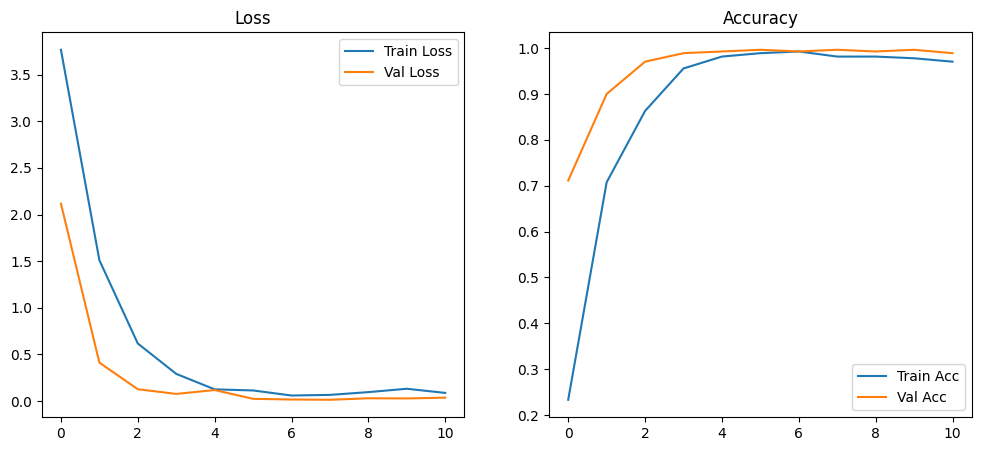

In [10]:
# Plot Training History
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Acc')
plt.plot(history['val_acc'], label='Val Acc')
plt.legend()
plt.title('Accuracy')
plt.show()

Error loading image Train\Lois Novel E Gurning\foto 3 - LOIS NOVEL E. GURNING.png: cannot identify image file 'Train\\Lois Novel E Gurning\\foto 3 - LOIS NOVEL E. GURNING.png'
Error loading image Train\Lois Novel E Gurning\foto 4 - LOIS NOVEL E. GURNING.png: cannot identify image file 'Train\\Lois Novel E Gurning\\foto 4 - LOIS NOVEL E. GURNING.png'
Error loading image Train\Martua Kevin A.M.H.Lubis\IMG_20241208_223409_653 - MARTUA KEVIN ANDREAS MUAL H LUBIS.jpg: [Errno 2] No such file or directory: 'Train\\Martua Kevin A.M.H.Lubis\\IMG_20241208_223409_653 - MARTUA KEVIN ANDREAS MUAL H LUBIS.jpg'


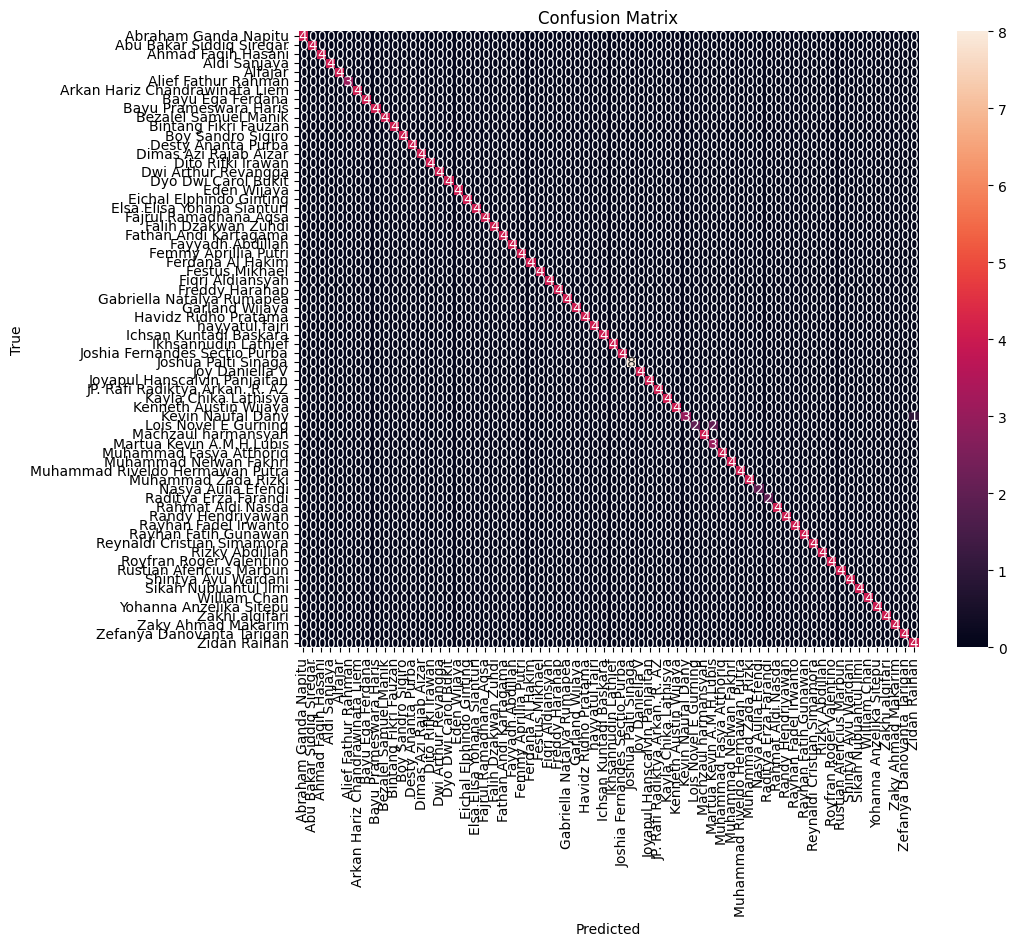

                                 precision    recall  f1-score   support

           Abraham Ganda Napitu       1.00      1.00      1.00         4
       Abu Bakar Siddiq Siregar       1.00      1.00      1.00         4
             Ahmad Faqih Hasani       1.00      1.00      1.00         4
                   Aldi Sanjaya       1.00      1.00      1.00         4
                        Alfajar       1.00      1.00      1.00         4
            Alief Fathur Rahman       1.00      1.00      1.00         3
 Arkan Hariz Chandrawinata Liem       1.00      1.00      1.00         4
               Bayu Ega Ferdana       1.00      1.00      1.00         4
          Bayu Prameswara Haris       1.00      1.00      1.00         4
           Bezalel Samuel Manik       1.00      1.00      1.00         4
           Bintang Fikri Fauzan       1.00      1.00      1.00         4
              Boy Sandro Sigiro       1.00      1.00      1.00         4
             Desty Ananta Purba       1.00      1.

In [11]:
# Confusion Matrix
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=list(label_map.keys()), yticklabels=list(label_map.keys()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(all_labels, all_preds, target_names=list(label_map.keys())))